In [1]:
from astropy.table import Table
import matplotlib as mpl

plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

data_file = 'volume_limited_sample.fits'
source_dir = '../../fits/' # Directory containing all of the FITS files

from prefig import Prefig
Prefig()
% matplotlib inline

colours = ['red','blue','green','cyan','orange','magenta','yellow','black'] # Oreder of colours to plot.

import pickle

In [2]:
# Make a dictionary of terms for each of the questions:

questions = {}

q = ['t01_smooth_or_features'
     ,'t02_edgeon'
     ,'t03_bar'
     ,'t04_spiral'
     ,'t05_bulge_prominence'
     ,'t06_odd'
     ,'t07_rounded'
     ,'t08_odd_feature'
     ,'t09_bulge_shape'
     ,'t10_arms_winding'
     ,'t11_arms_number']

label_q = ['Smooth or features'
     ,'Edge on'
     ,'Bar'
     ,'Spiral'
     ,'Bulge prominence'
     ,'Anything odd'
     ,'Roundedness'
     ,'Odd features'
     ,'Bulge shape'
     ,'Arm winding'
     ,'Arm number']

a = [['a01_smooth','a02_features_or_disk','a03_star_or_artifact']
     ,['a04_yes','a05_no']
     ,['a06_bar','a07_no_bar']
     ,['a08_spiral','a09_no_spiral']
     ,['a10_no_bulge','a11_just_noticeable','a12_obvious','a13_dominant']
     ,['a14_yes','a15_no']
     ,['a16_completely_round','a17_in_between','a18_cigar_shaped']
     ,['a19_ring','a20_lens_or_arc','a21_disturbed','a22_irregular','a23_other','a24_merger','a38_dust_lane']
     ,['a25_rounded','a26_boxy','a27_no_bulge']
     ,['a28_tight','a29_medium','a30_loose']
     ,['a31_1','a32_2','a33_3','a34_4','a36_more_than_4','a37_cant_tell']]

label_a = [['Smooth','Features','Artifact']
     ,['Yes','No']
     ,['Yes','No']
     ,['Yes','No']
     ,['None','Noticeable','Obvious','Dominant']
     ,['Yes','No']
     ,['Round','In between','Cigar shaped']
     ,['Ring','Lens/Arc','Disturbed','Irregular','Other','Merger','Dust lane']
     ,['Rounded','Boxy','None']
     ,['Tight','Medium','Loose']
     ,['1','2','3','4','5+','??']]

pre_q = [None
         ,[0]
         ,[0,1]
         ,[0,1]
         ,[0,1]
         ,None
         ,[0]
         ,[5]
         ,[0,1]
         ,[0,1,3]
         ,[0,1,3]]

pre_a = [None
         ,[1]
         ,[1,1]
         ,[1,1]
         ,[1,1]
         ,None
         ,[0]
         ,[0]
         ,[1,1]
         ,[1,1,0]
         ,[1,1,0]]

for s in range(len(q)):
    
    if pre_q[s] is not None:
        pq = [q[v] for v in pre_q[s]] 
    else:
        pq = None
    
    questions[q[s]] = {'answers': a[s]
                       ,'answerlabels': label_a[s]
                       ,'questionlabel': label_q[s]
                       ,'pre_questions': pq}
    
    if pre_a[s] is not None:
        pa_array = [questions[q[v]]['answers'] for v in pre_q[s]]
        answer_arrays = [pa_array[v] for v in range(len(pre_a[s]))]
        answer_indices = [pre_a[s][v] for v in range(len(pre_a[s]))]
        pa = [answer_arrays[v2][answer_indices[v2]] for v2 in range(len(answer_indices))]
 
    else:
        pa = None
    
    questions[q[s]].update({'pre_answers': pa})

In [3]:
with open(source_dir + 'questions.pickle', 'wb') as h:
    pickle.dump(questions, h)

In [4]:
vl_data = fits.getdata(source_dir + data_file,1)
vl_data = Table(vl_data)

debiased_data = fits.getdata('../../Debiasing_code_format/Codes/npy/'+ 'vl_sample_debiased.fits')
debiased_data = Table(debiased_data)

In [61]:
def select_data(debiased_data,data,question_dict,question,p_threshold=0.5,N_threshold=0):
    
    p_values = np.ones(len(data))
    # Load question + answer criteria:
    pre_questions = question_dict[question]['pre_questions']
    pre_answers = question_dict[question]['pre_answers']
    # Select by p and N(checking if there are any pre-select questions at all):
    if pre_questions == None:
        p_values = np.ones(len(data))
        N_values = np.ones(len(data))*(10**8) # Arbitrarily high number
    else:
        p_criteria = [pre_questions[v] + '_' + pre_answers[v] + '_debiased' for v in range(len(pre_questions))]
        for c in p_criteria:
            p_values = p_values*debiased_data[c]
        N_values = data[pre_questions[-1] + '_' + pre_answers[-1] + '_count'] 
    
    selection = (p_values > p_threshold) #& (N_values >= N_threshold)
    #selected_data = data[selection]
    
    return selection

In [62]:
# Here just plot the raw fractions as a function of redshift

def plot_means(data,debiased_data,debiasing_type,question_dict
               ,bins=np.arange(0.03,0.085+10**-10,0.005),plot='raw fractions'
               ,threshold=0.5,question='t01_smooth_or_features'):
    
    question_label = question_dict[question]['questionlabel']
    answer_labels = question_dict[question]['answerlabels']
    debiased_answers = [question + '_' + a + '_debiased' for a in question_dict[question]['answers']]
    raw_answers = [question + '_' + a + '_weighted_fraction' for a in question_dict[question]['answers']]
    
    if debiasing_type == 'willett13':
        debiased_data = data
    
    select = select_data(debiased_data,data,question_dict,question)
    debiased_data = debiased_data[select]
    D = data[select]

    if debiasing_type == 'willett13':
        debiased_data = D[debiased_answers]
    def get_mean_values(D,bins):
        return [np.mean(D[bins == b]) for b in np.unique(bins)]
    
    bin_assignments = np.digitize(D['REDSHIFT_1'],bins=bins)
    
    if plot == 'raw fractions':
            f = get_mean_values
    else:
        def f(data,bins,threshold=threshold):
            return [(np.sum(data[bins == b] > threshold)/len(data[bins == b])) for b in np.unique(bins)]

    for col in range(len(raw_answers)):
        
        raw = f(D[raw_answers[col]],bin_assignments)
        debiased = f(debiased_data[debiased_answers[col]],bin_assignments)
        redshift = get_mean_values(D['REDSHIFT_1'],bin_assignments)
        
        plt.plot(redshift,raw,color=colours[col],linestyle='solid',linewidth=2,label=answer_labels[col])
        plt.plot(redshift,debiased,color=colours[col],linestyle='dashed',linewidth=1.5)
        plt.ylim(0,1)
        plt.xlim(0.02,0.09)
        
        if len(question_label) < 10:
            plt.text(0.5,0.98,question_label + ' ({} galaxies)'.format(len(D)),family='serif'
                     ,horizontalalignment='center',verticalalignment='top'
                     ,transform = plt.gca().transAxes,size=15)
        else:
            plt.text(0.5,0.98,question_label,family='serif'
                     ,horizontalalignment='center',verticalalignment='top'
                     ,transform = plt.gca().transAxes,size=15)
            plt.text(0.5,0.94,' ({} galaxies)'.format(len(D)),family='serif'
                     ,horizontalalignment='center',verticalalignment='top'
                     ,transform = plt.gca().transAxes,size=15)
            
        plt.legend(bbox_to_anchor=(0,0,1,1),bbox_transform=plt.gca().transAxes)
        
    return None

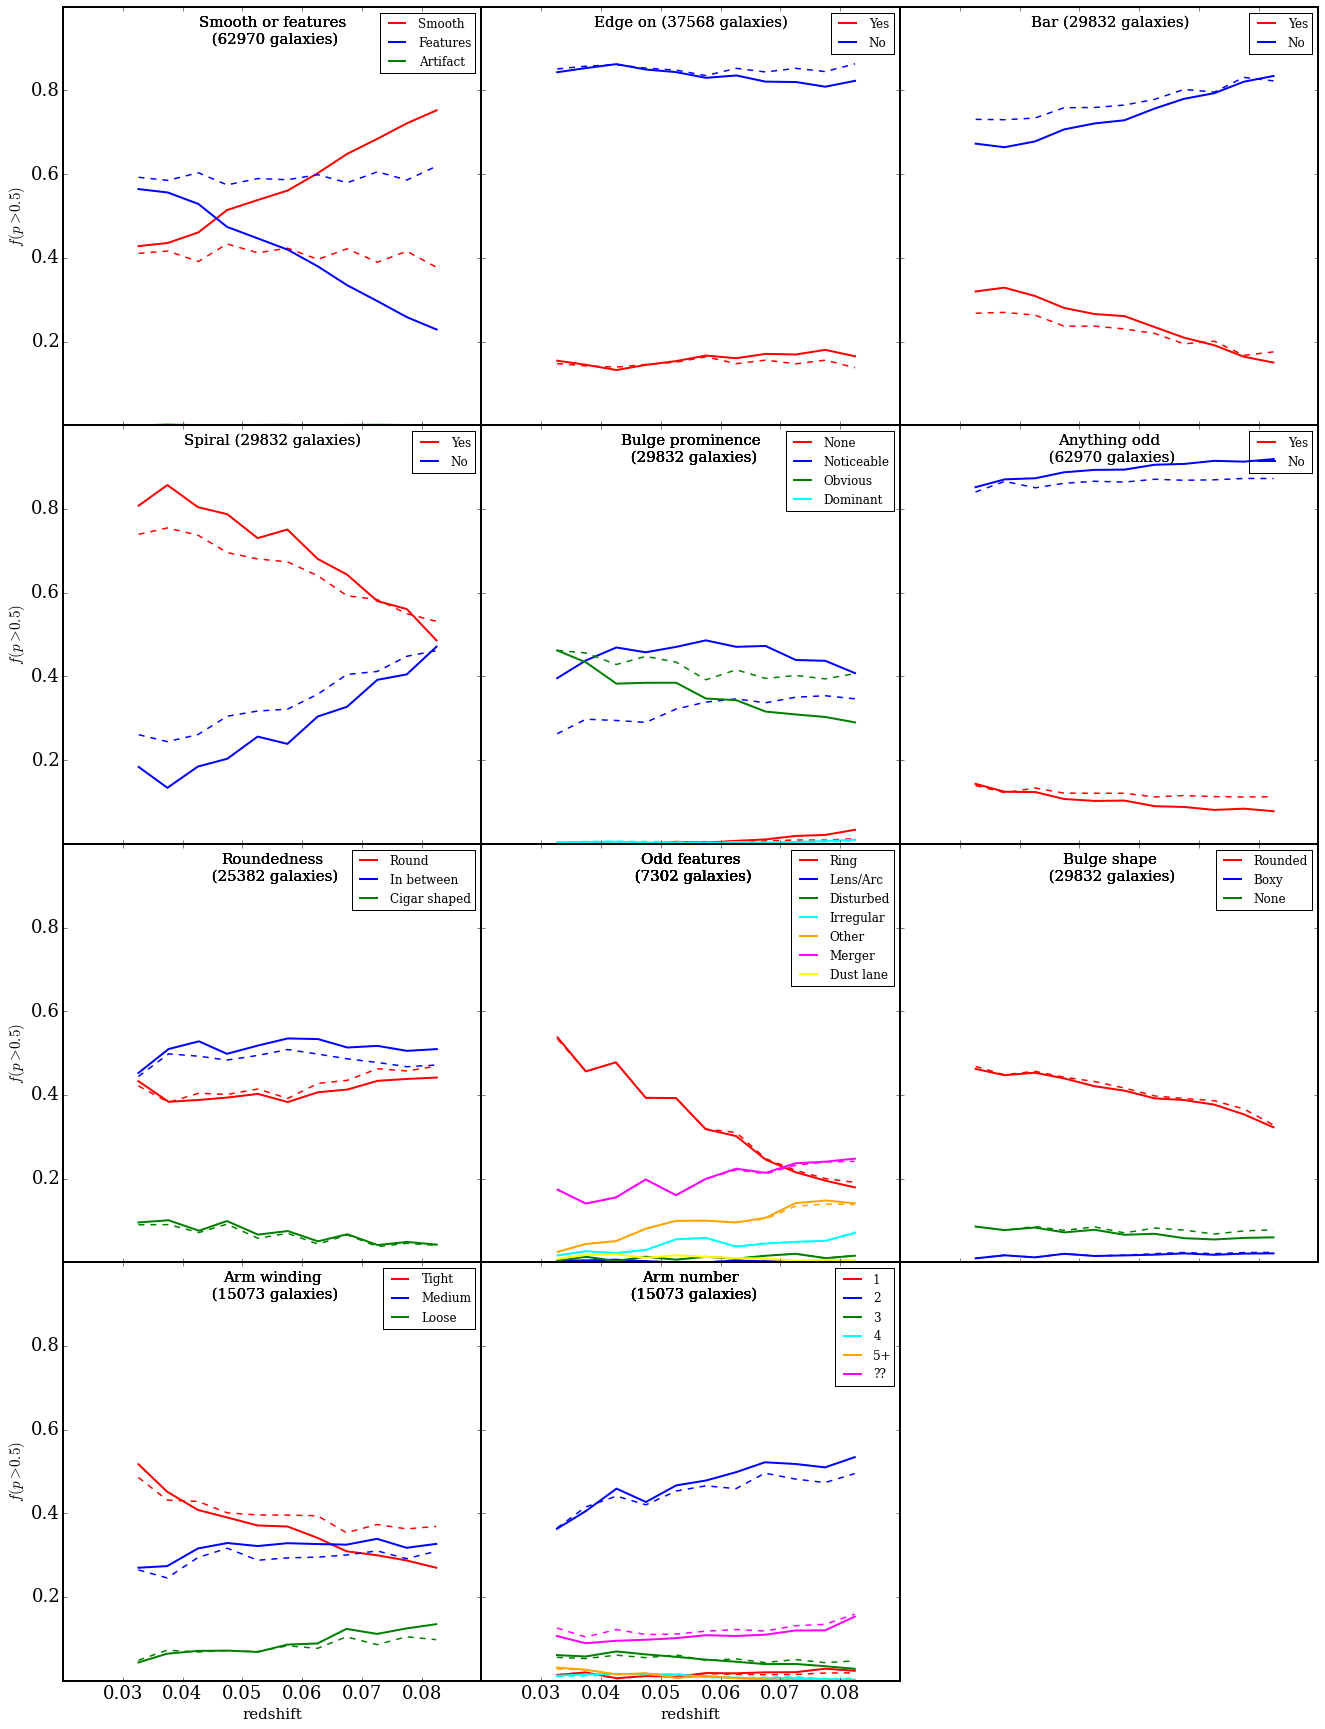

In [63]:
fig,axes = plt.subplots(4,3,figsize=(22.5,30),sharex=True,sharey=True)
for ax in axes[:,0]:
    ax.set_ylabel('$f(p>0.5)$',size=15)
for ax in axes[-1]:
    ax.set_xlabel('redshift',size=15)

axes = axes.ravel()
fig.delaxes(axes[-1])
plt.subplots_adjust(hspace=0,wspace=0)

for Q in enumerate(q):
    
    plt.sca(axes[Q[0]])
    plot_means(vl_data,debiased_data,'willett13',questions,plot='',question=Q[1])

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in greater
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in greater


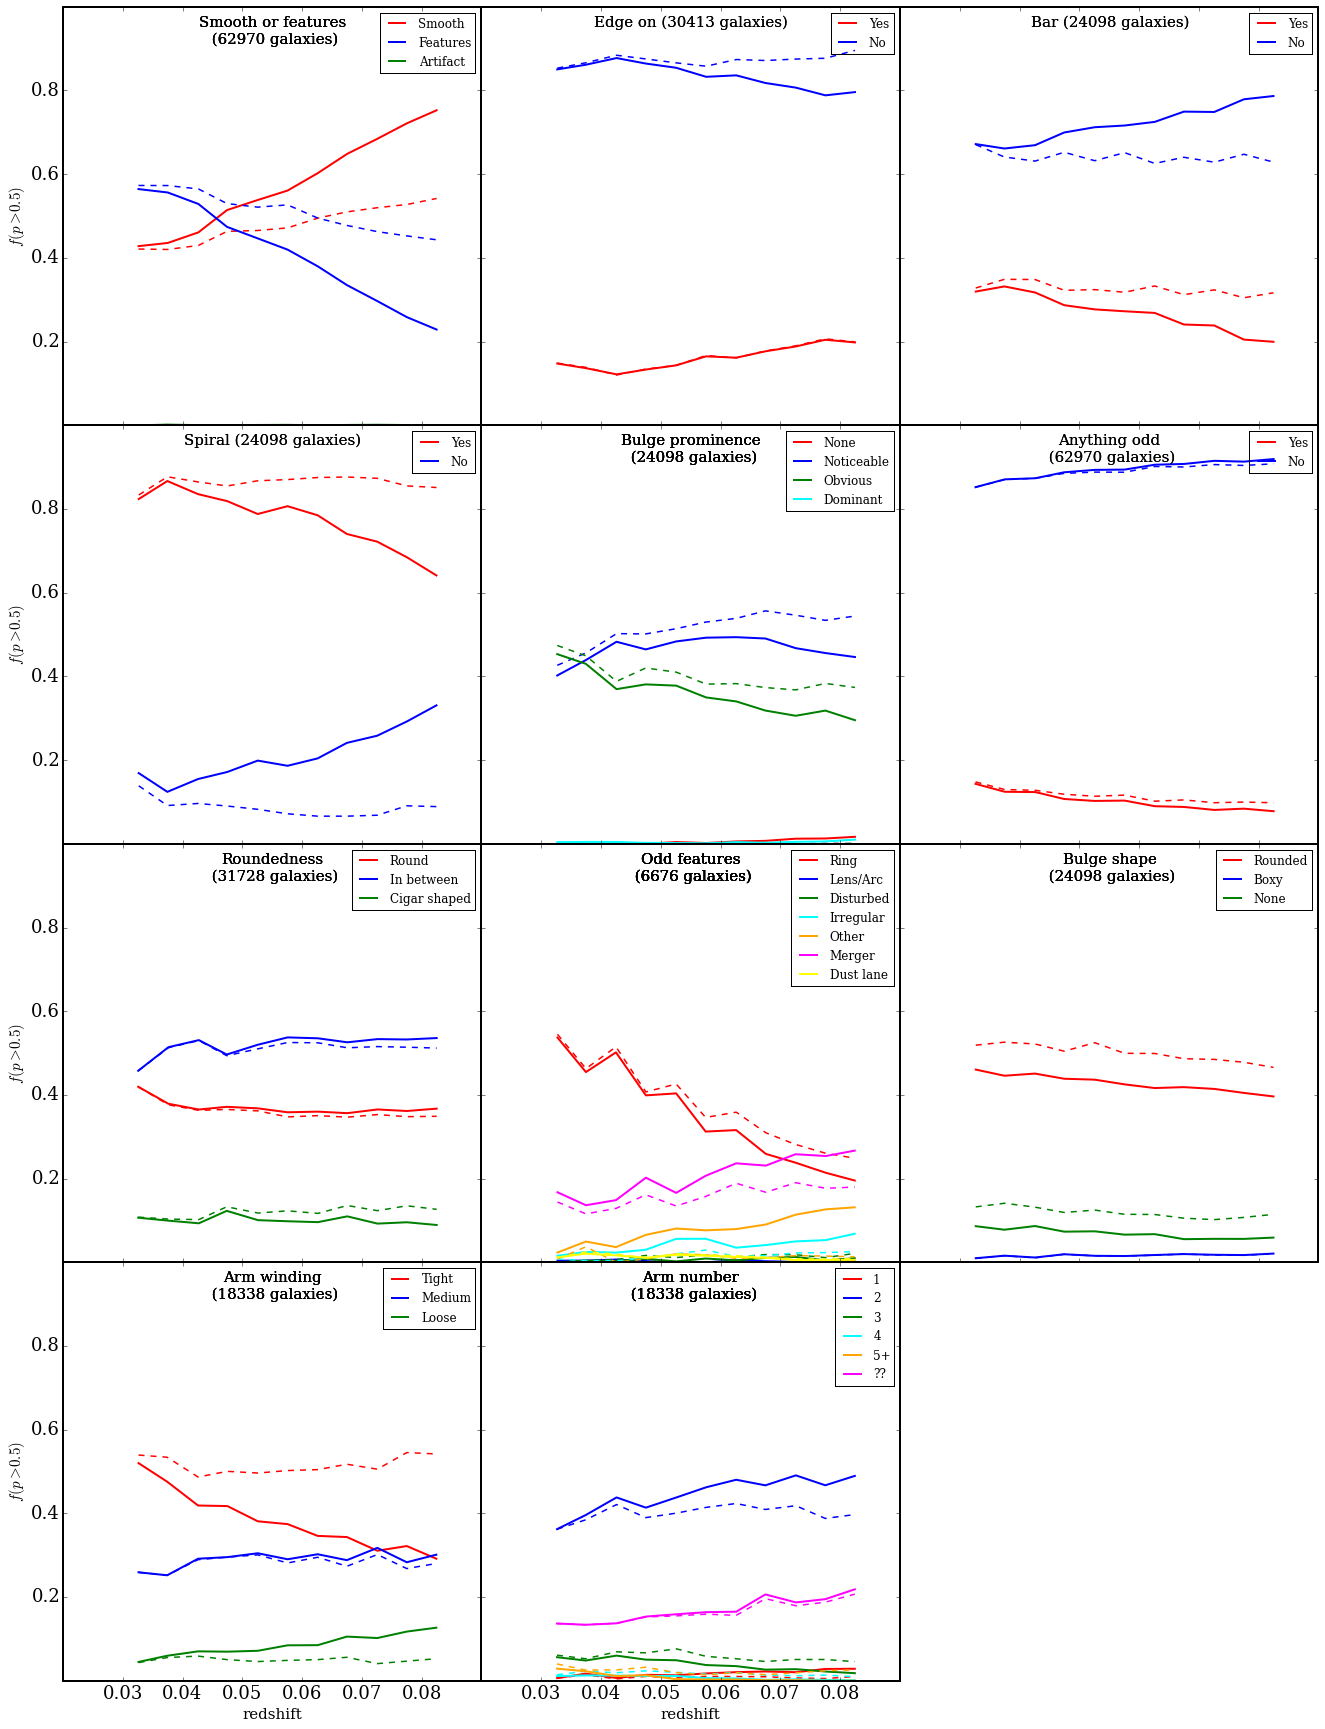

In [64]:
fig,axes = plt.subplots(4,3,figsize=(22.5,30),sharex=True,sharey=True)
for ax in axes[:,0]:
    ax.set_ylabel('$f(p>0.5)$',size=15)
for ax in axes[-1]:
    ax.set_xlabel('redshift',size=15)

axes = axes.ravel()
fig.delaxes(axes[-1])
plt.subplots_adjust(hspace=0,wspace=0)

for Q in enumerate(q):
    
    plt.sca(axes[Q[0]])
    plot_means(vl_data,debiased_data,'',questions,plot='',question=Q[1])

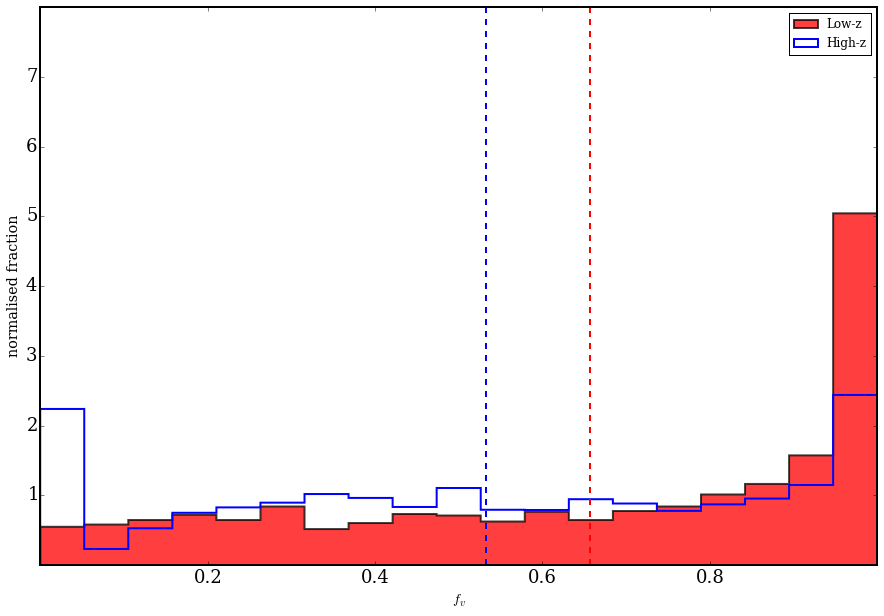

In [64]:
# Plot up the spiral vote fraction histograms?
fig = plt.figure(figsize=(15,10))

Q = 't04_spiral'

bins=np.arange(0.03,0.085+10**-10,0.005)
D = select_data(vl_data,questions,question=Q)
bin_assignments = np.digitize(D['REDSHIFT_1'],bins=bins)

styles = ['stepfilled','step']
alphas = [0.75,1]
labels = ['Low-z','High-z']

for B in enumerate([np.min(bin_assignments)+5,np.max(bin_assignments)]):
    
    s_data = D[bin_assignments == B[1]]
    
    debiased_answer = [Q + '_' + questions[Q]['answers'][0] + '_debiased']
    
    v = np.array(s_data[debiased_answer]).astype(float)
    plt.hist(v,bins=np.linspace(0,1,20),normed=True,label=labels[B[0]]
             ,histtype=styles[B[0]],color=colours[B[0]],linewidth=2,alpha=alphas[B[0]])
    plt.vlines(np.mean(v),0,8,color=colours[B[0]],linestyle='dashed')
    plt.legend()
    plt.xlabel('$f_v$')
    plt.ylabel('normalised fraction')
    
# Although not disastrous, we do seem to be significantly undersampling the spiral galaxies a fair amount.
# I would suggest that this tends to happen when we have a lot of 1s at low redshift that don't translate
# to the high redshift cases very well.